# 1. Preprocess Data and Create Labels and Features

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import pandas as pd

In [2]:
#Define Path to training data of numpy arrays

DATA_PATH = os.path.join('MP_Data') # including facemesh

# Define Model Run
run = 'run'

#Define directory to save training graphs and confusion matrices
img_dir = f'Logs/{run}/images'

# create directory if image directory does not exist
if not os.path.exists(img_dir):
    os.makedirs(img_dir)    

# Define actions that we try to detect
actions = np.array(['no', 'please', 'thanks', 'welcome', 'yes', 'noaction'])

# Sixty videos worth of data for each action
no_sequences = 60
# Videos are going to be 30 frames in length (30 frames of data for each action)
sequence_length = 30

#create label map dictionary
label_map = {label:num for num, label in enumerate(actions)} 
print(label_map)

#sequences represent x data, labels represent y data/the action classes.
sequences, labels = [], []
#Loop through the action classes you want to detect
for action in actions:
    #loop through each sequence
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

# X = Training Data that contains spatial coordinates x,y,z of landmarks
X = np.array(sequences)

# y = categorical labels
y = to_categorical(labels).astype(int) #one-hot-encoding to catergorical variable

print('X Shape:',X.shape)
print('y Shape:',y.shape)

# train test split (80% train,20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

print('X_train Shape:',X_train.shape)
print('y_train Shape:',y_train.shape)
print('X_test Shape:',X_test.shape)
print('y_test Shape:',y_test.shape)

# split imbalanced dataset into train and test sets with stratification
test_count_label = tf.reduce_sum(y_test, axis=0)
train_count_label = tf.reduce_sum(y_train, axis=0)

{'no': 0, 'please': 1, 'thanks': 2, 'welcome': 3, 'yes': 4, 'noaction': 5}
X Shape: (360, 30, 258)
y Shape: (360, 6)
X_train Shape: (288, 30, 258)
y_train Shape: (288, 6)
X_test Shape: (72, 30, 258)
y_test Shape: (72, 6)


In [3]:
# Show categorical list
actions.tolist()

['no', 'please', 'thanks', 'welcome', 'yes', 'noaction']

In [4]:
left = pd.DataFrame(train_count_label,columns=['train_count'])
right = pd.DataFrame(test_count_label,columns=['test_count'])
df = left.join(right)

actions_list = actions.tolist()

left = pd.DataFrame(actions_list,columns=['class_names'])
df = left.join(df)
df

,class_names,train_count,test_count
0,no,48,12
1,please,48,12
2,thanks,48,12
3,welcome,48,12
4,yes,48,12
5,noaction,48,12


In [5]:
left = pd.DataFrame(train_count_label,columns=['train_count'])
right = pd.DataFrame(test_count_label,columns=['test_count'])
df = left.join(right)

actions_list = actions.tolist()

left = pd.DataFrame(actions_list,columns=['class_names'])
df = left.join(df)
df

,class_names,train_count,test_count
0,no,48,12
1,please,48,12
2,thanks,48,12
3,welcome,48,12
4,yes,48,12
5,noaction,48,12


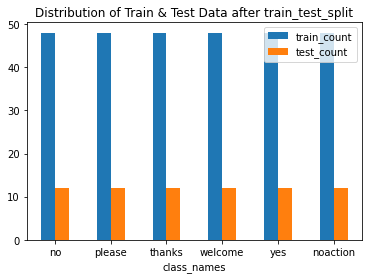

In [6]:
# Plot Distribution of Train & Test Data after train_test_split
ax = df.plot.bar(x='class_names',rot=0)
ax.set_title('Distribution of Train & Test Data after train_test_split')
ax.figure.savefig('Logs/run/images/train_test_distribution.jpg')

# 2. Training LSTM Model

In [7]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

#Set up log directory to monitor training accuracy while training
log_dir = os.path.join('Logs/{}'.format(run))
tb_callback = TensorBoard(log_dir=log_dir)

model_dir = 'Logs/{}/model_LSTM'.format(run)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [8]:
# Build LSTM Model Architecture Layers using Keras high-level

modelLSTM = Sequential()
modelLSTM.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
modelLSTM.add(Dropout(0.2))
modelLSTM.add(LSTM(128, return_sequences=True, activation='relu'))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(LSTM(64, return_sequences=False, activation='relu')) 
modelLSTM.add(Dense(32, activation='relu'))
modelLSTM.add(Dense(actions.shape[0], activation='softmax'))

In [9]:
#Compile defines the loss function, the optimizer and the metrics. 
modelLSTM.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [10]:
modelLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            82688     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 6)                 1

In [34]:
epochs = 100
#checkpoint_dir = f"Logs/{run}/tmp/checkpoint"
model_filename = "Epoch-{epoch:02d}-Loss-{val_loss:.2f}.h5"
checkpoint_filepath = os.path.join('model_LSTM/',model_filename)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'Logs/{run}/'+checkpoint_filepath,
    monitor='val_loss', #get the minimum validation loss
    mode='min',
    save_weights_only=True,
    save_best_only=True,
    verbose=2)

# Reference: https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd
early_stopping =EarlyStopping(monitor='val_loss', patience=20, mode='auto',verbose=2)

In [35]:
#DO NOT RUN IF DONT WANT TO TRAIN
# Reference: https://www.tensorflow.org/guide/keras/train_and_evaluate
print(f"Fit model on training data for {epochs} epochs")
history_LSTM = modelLSTM.fit(
    X_train, y_train, 
    #batch_size=64,
    epochs=epochs,
    # We pass some validation data for monitoring validation loss and metrics at the end of each epoch
    validation_data=(X_test, y_test),
    verbose=2,
    batch_size=32,
    callbacks=[tb_callback, model_checkpoint_callback, early_stopping]
)

#https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network


Fit model on training data for 100 epochs
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.06756, saving model to Logs/run/model_LSTM\Epoch-01-Loss-0.07.h5
9/9 - 1s - loss: 0.0132 - categorical_accuracy: 0.9965 - val_loss: 0.0676 - val_categorical_accuracy: 0.9583 - 575ms/epoch - 64ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.06756 to 0.02886, saving model to Logs/run/model_LSTM\Epoch-02-Loss-0.03.h5
9/9 - 1s - loss: 0.0225 - categorical_accuracy: 0.9931 - val_loss: 0.0289 - val_categorical_accuracy: 0.9861 - 543ms/epoch - 60ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 0.02886
9/9 - 1s - loss: 0.0131 - categorical_accuracy: 0.9931 - val_loss: 0.0948 - val_categorical_accuracy: 0.9583 - 565ms/epoch - 63ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.02886
9/9 - 1s - loss: 0.0340 - categorical_accuracy: 0.9931 - val_loss: 0.2230 - val_categorical_accuracy: 0.9167 - 527ms/epoch - 59ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.02

# 3. Plot Training Results

In [36]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_LSTM.history) 

hist_df.to_csv(f'./Logs/{run}/history_LSTM.csv',index = False)

df_hist = pd.read_csv(f'./Logs/{run}/history_LSTM.csv')
hist_df

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,0.013217,0.996528,0.067560,0.958333
1,0.022534,0.993056,0.028863,0.986111
2,0.013065,0.993056,0.094794,0.958333
3,0.033966,0.993056,0.223007,0.916667
4,0.156586,0.951389,0.806468,0.819444
5,0.088240,0.958333,0.315344,0.930556
6,0.109597,0.965278,0.085211,0.972222
7,0.045475,0.986111,0.075896,0.986111
8,0.024451,1.000000,0.135734,0.958333
9,0.013851,1.000000,0.087135,0.958333


In [37]:
min_loss_epoch = hist_df[hist_df['loss']==min(hist_df['loss'])].index.values
min_loss = min(hist_df['loss'])
print('Index of Minimum Loss =',min_loss_epoch[0])
print('Minimum Loss =',round(min_loss,2))

Index of Minimum Loss = 18
Minimum Loss = 0.0


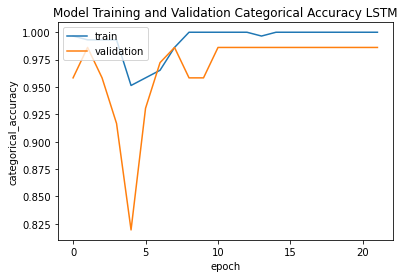

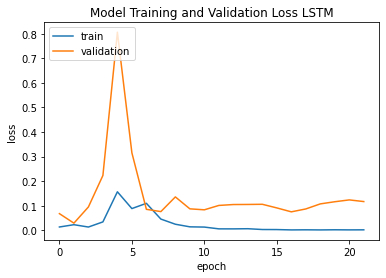

In [38]:
# summarize history for accuracy
plt.plot(history_LSTM.history['categorical_accuracy'])
plt.plot(history_LSTM.history['val_categorical_accuracy'])
plt.title('Model Training and Validation Categorical Accuracy LSTM')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(f'{img_dir}/Model Training and Validation Categorical Accuracy LSTM.jpg')
plt.show()

# summarize history for loss
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('Model Training and Validation Loss LSTM')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(f'{img_dir}/Model Training and Validation Loss LSTM.jpg')
plt.show()

# 4. Load Best Model Weights/Checkpoint

In [39]:
#PATH: "C:\Users\yasmi\Desktop\data science\Logs\run_version2training\model\Epoch-72-Loss-0.15.h5"

modelLSTM.load_weights("C:/Users/yasmi/Desktop/finalized ds project/Logs/run/model_LSTM/Epoch-52-Loss-0.01.h5")

# 7. Make Predictions on X_test

In [40]:
res = modelLSTM.predict(X_test)

# Get y_predict and apply softmax function
np.argmax(res[6])

3/3 [==============================] - 1s 16ms/step


0

In [41]:
# Predicted Action
actions[np.argmax(res[4])]

'yes'

In [42]:
# Actual Action
actions[np.argmax(y_test[4])]

'yes'

# 8. Model Evaluation (Categorical Accuracy and Confusion Matrix)
Running these cells converts the predicition from their one-hot encoded representation to a categorical label e.g. 0,1 or 2 as opoosed to [1,0,0], [0,1,0] or [0,0,1].

In [43]:
X_test.shape

(72, 30, 258)

In [44]:
label_list = ['no', 'please', 'thanks', 'welcome', 'yes', 'noaction']
label_list

['no', 'please', 'thanks', 'welcome', 'yes', 'noaction']

In [45]:
label_list = list(label_map.keys())
label_list

['no', 'please', 'thanks', 'welcome', 'yes', 'noaction']

In [46]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def generate_confusion_matrix_accuracy(X,y,types):
    predictions = modelLSTM.predict(X)
    y_true = np.argmax(y, axis=1)
    y_pred = np.argmax(predictions, axis=1)
    cm = confusion_matrix(y_true, y_pred)

    print(f'{types} Overall Multiclassification Accuracy Score across all classes:',round(accuracy_score(y_true, y_pred),2))

    sns.heatmap(cm, xticklabels = label_list, yticklabels = label_list, annot = True, linewidths = 0.1, fmt='d',cmap='Blues') # cmap = 'YlGnBu')
    plt.title(f"{types} Confusion matrix", fontsize = 15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

9/9 [==============================] - 0s 19ms/step
Train Overall Multiclassification Accuracy Score across all classes: 0.99


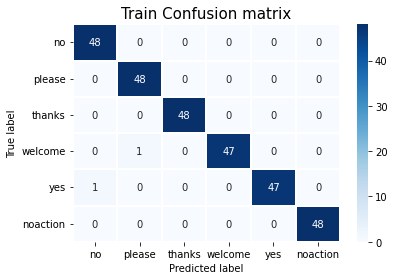

In [47]:
generate_confusion_matrix_accuracy(X_train,y_train,'Train')

3/3 [==============================] - 0s 17ms/step
Test Overall Multiclassification Accuracy Score across all classes: 1.0


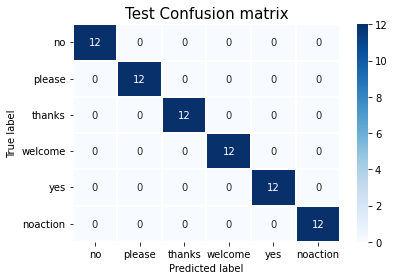

In [48]:
generate_confusion_matrix_accuracy(X_test,y_test,'Test')

In [49]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# predict on test data
y_pred = modelLSTM.predict(X_test)

# convert predictions to binary labels
y_pred = (y_pred > 0.5)

# calculate precision, recall, f1-score, and accuracy
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1_score)
print("Accuracy: ", accuracy)



3/3 [==============================] - 0s 17ms/step
Precision:  [1. 1. 1. 1. 1. 1.]
Recall:  [1. 1. 1. 1. 1. 1.]
F1-Score:  [1. 1. 1. 1. 1. 1.]
Accuracy:  1.0


# Run Real Time Keypoint Detection Model Using Webcam

In [52]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [53]:
# Use Holistic Models for detections
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities


# Make keypoint detection, model can only detect in RGB
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB as model can only detect in RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Use Model to make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results): # draw landmarks for each image/frame
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections
    
def draw_styled_landmarks(image, results): # draw landmarks for each image/frame, fix colour of landmark drawn
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [56]:
# use computer webcam and make keypoint detections
cap = cv2.VideoCapture(0)

# Set mediapipe model configurations
min_detection_confidence = 0.5
min_tracking_confidence= 0.5

with mp_holistic.Holistic(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections by calling our function
        image, results = mediapipe_detection(frame, holistic) #mediapipe_detection(image, model) 
        #print(results)
        #print(results.face_landmarks)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed: Hold Q to Quit', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'): #press q to quit
            break
            
    cap.release() #release webcam
    cv2.destroyAllWindows()

In [58]:
#Show length of landmarks x,y,z spatial coordinates for left hand pose
len(results.left_hand_landmarks.landmark)

21

In [59]:
# Show Results of landmark x,y,z spatial coordinates for face landmarks
print('Length of face landmarks:',len(results.face_landmarks.landmark))
print('Results Type:',type(results.face_landmarks))
print('Face landmarks Results:',results.face_landmarks)

# Convert facelandmarks to numpy array
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark])if results.face_landmarks else np.zeros(468*3)
print(face)

Length of face landmarks: 468
Results Type: <class 'mediapipe.framework.formats.landmark_pb2.NormalizedLandmarkList'>
Face landmarks Results: landmark {
  x: 0.5276355
  y: 0.7832757
  z: -0.030849038
}
landmark {
  x: 0.53028053
  y: 0.7412408
  z: -0.04574886
}
landmark {
  x: 0.5283882
  y: 0.7570146
  z: -0.026685458
}
landmark {
  x: 0.52186584
  y: 0.7048027
  z: -0.031005591
}
landmark {
  x: 0.53056705
  y: 0.72862506
  z: -0.047468595
}
landmark {
  x: 0.5301498
  y: 0.7138967
  z: -0.04259999
}
landmark {
  x: 0.52835816
  y: 0.6807255
  z: -0.014788392
}
landmark {
  x: 0.46247745
  y: 0.6866425
  z: 0.013305527
}
landmark {
  x: 0.5279665
  y: 0.65069705
  z: -0.005749192
}
landmark {
  x: 0.5282318
  y: 0.6334749
  z: -0.005337843
}
landmark {
  x: 0.5277184
  y: 0.5802077
  z: 0.011046806
}
landmark {
  x: 0.52741784
  y: 0.78941125
  z: -0.030231697
}
landmark {
  x: 0.5269968
  y: 0.79468054
  z: -0.027610201
}
landmark {
  x: 0.52655494
  y: 0.7973656
  z: -0.024104167

In [60]:
# Show Pose Connection Results
print('Pose Connection Results:',mp_holistic.POSE_CONNECTIONS)

# Get the landmarks x,y,z coordinates
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)
print(pose)

Pose Connection Results: frozenset({(15, 21), (16, 20), (18, 20), (3, 7), (14, 16), (23, 25), (28, 30), (11, 23), (27, 31), (6, 8), (15, 17), (24, 26), (16, 22), (4, 5), (5, 6), (29, 31), (12, 24), (23, 24), (0, 1), (9, 10), (1, 2), (0, 4), (11, 13), (30, 32), (28, 32), (15, 19), (16, 18), (25, 27), (26, 28), (12, 14), (17, 19), (2, 3), (11, 12), (27, 29), (13, 15)})
[array([ 0.52472478,  0.7340914 , -1.10776818,  0.99989814]), array([ 0.54581964,  0.67478311, -1.02877855,  0.99991626]), array([ 0.56056601,  0.67427295, -1.028741  ,  0.99992311]), array([ 0.57366288,  0.67590791, -1.02876043,  0.9999243 ]), array([ 0.49141198,  0.68330121, -1.03843856,  0.99987751]), array([ 0.47008991,  0.68765366, -1.03795159,  0.99986279]), array([ 0.45299092,  0.69316798, -1.03794217,  0.99981606]), array([ 0.59186786,  0.7115171 , -0.56787997,  0.99996912]), array([ 0.42959809,  0.73392797, -0.59756207,  0.99988663]), array([ 0.55696356,  0.79809105, -0.9389286 ,  0.99993825]), array([ 0.49193549,

In [61]:
# Using list comprehension to extract landmark results if landmark for body part is detected, else replace it with a blank array of zeros of the same shape for each body part    
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [62]:
print(pose.shape)
print(face.shape)
print(lh.shape)
print(rh.shape)

(132,)
(1404,)
(63,)
(63,)


In [63]:
# Define extract keypoint function and convert to numpy array to be saved
# Exculde face keypoints
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    #face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    #return np.concatenate([pose, face, lh, rh]) # concatenate all the keypoints that are flattened
    return np.concatenate([pose, lh, rh])

result_test = extract_keypoints(results)

In [64]:
colors = [(245,221,173), (245,185,265), (146,235,193),(204,152,295),(255,217,179),(0,0,179)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [66]:
#New detection variables

#collect 30 frames
sequence = []

#concantenate 
sentence = []

#confident matrix
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = modelLSTM.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 24ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
noac

1/1 [==============================] - 0s 26ms/step
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
no
<class 'mediapipe.python.solution_base.SolutionOu

1/1 [==============================] - 0s 27ms/step
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
no
<class 'mediapipe.python.solution_base.SolutionOu

1/1 [==============================] - 0s 27ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
noac

noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
noaction
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
noaction
<class 'mediapipe.python.solution_base.Solution

1/1 [==============================] - 0s 20ms/step
yes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
yes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
yes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
yes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
yes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
yes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
yes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
yes
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
yes
<class 'mediapipe.python.solution_base.S